## Project Overview:
This project aims to use data from an artificial pancreas medical control system to predict insulin dosage timings based on glucose readings. The objective is to differentiate between meal-related and non-meal-related glucose fluctuations and train machine learning models to predict crucial times for insulin injections.

### Data Description:
InsulinData.csv: This dataset contains information about meal times, captured through manual entries of carbohydrate intake. The dataset comprises approximately 40,000 rows, each indicating the time a meal was consumed and the amount of carbohydrates.

CGMData.csv: Contains continuous glucose monitoring data with glucose levels (mg/dL) recorded every 5 minutes, totaling approximately 55,000 rows. This dataset provides a detailed temporal profile of glucose variations throughout the day.

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import math

In [297]:
# Model Selection and Validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Metrics and Reporting
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

#Scaler
from sklearn.preprocessing import StandardScaler

In [147]:
# Load Data 
df = pd.read_csv('InsulinData.csv', low_memory=False)
df2 = pd.read_csv('CGMData.csv', low_memory=False)

### Filtering Relevant Data:
From InsulinData.csv, times where carbohydrate input is greater than 0 and less than 1000 grams are retained for analysis.
Time stamps are converted to pandas datetime objects to facilitate time-based operations.

### Extracting Meal and No-Meal Periods:
Meal Data: Identified by a 2-hour window post each recorded meal time.

No-Meal Data: Identified as any 2-hour window where no meal was recorded preceding the interval.

In [149]:
# retrieve rows with carb value greater than 0 and less than 1000
grams = df.loc[(df['BWZ Carb Input (grams)'] <= 1000) 
                & (df['BWZ Carb Input (grams)'] > 0)]
    
# length of data
i = len(grams) - 1
    
# retrieve the times of meal data
outtime, carblist = [],[]
    
# start from the bottom of the file, iterate through every row
while i > 0:
    date_time0 = pd.to_datetime(grams.iloc[i - 1, 1] + ' ' + grams.iloc[i - 1, 2])
    date_time1 = pd.to_datetime(grams.iloc[i - 2, 1] + ' ' + grams.iloc[i - 2, 2])
    carb = grams.iloc[i - 1, 24]

    # there is no meal within 2 hours stretch of time
    if (date_time1 >= (date_time0 + timedelta(days=0, hours=2))):
        outtime.append(str(date_time0))
        carblist.append(carb)
    i = i - 1

maxcarb = max(carblist)
mincarb = min(carblist)

nobins = math.floor((maxcarb - mincarb) / 20)
binrange = (maxcarb - mincarb) / nobins 

# convert times to pd times
insulin_meal_times = pd.to_datetime(outtime)
insulin_meal_times

DatetimeIndex(['2017-07-25 10:39:46', '2017-07-25 18:31:40',
               '2017-07-26 12:48:41', '2017-07-26 19:15:06',
               '2017-07-27 05:45:51', '2017-07-27 09:19:41',
               '2017-07-27 13:56:49', '2017-07-27 18:58:04',
               '2017-07-28 08:49:55', '2017-07-28 15:16:56',
               ...
               '2018-02-08 22:24:34', '2018-02-09 10:21:46',
               '2018-02-09 15:07:13', '2018-02-10 14:48:11',
               '2018-02-10 19:46:28', '2018-02-11 10:02:19',
               '2018-02-11 12:43:23', '2018-02-11 18:14:37',
               '2018-02-11 20:33:18', '2018-02-12 02:30:55'],
              dtype='datetime64[ns]', length=603, freq=None)

In [151]:
# convert time in CGM file to pd time
cgm_meal_times = pd.to_datetime((df2['Date'] + ' ' + df2['Time']).tolist())
cgm_meal_times

DatetimeIndex(['2018-02-12 13:22:27', '2018-02-12 13:17:27',
               '2018-02-12 13:12:27', '2018-02-12 13:07:27',
               '2018-02-12 13:02:27', '2018-02-12 12:57:27',
               '2018-02-12 12:52:27', '2018-02-12 12:47:27',
               '2018-02-12 12:42:27', '2018-02-12 12:37:27',
               ...
               '2017-07-25 12:53:54', '2017-07-25 12:48:54',
               '2017-07-25 12:43:54', '2017-07-25 12:38:54',
               '2017-07-25 12:33:54', '2017-07-25 12:28:54',
               '2017-07-25 12:23:54', '2017-07-25 12:18:54',
               '2017-07-25 12:13:54', '2017-07-25 12:08:54'],
              dtype='datetime64[ns]', length=55343, freq=None)

### Data Segmentation and Structuring for Analysis
This segment of the code is responsible for extracting and structuring glucose level data from continuous glucose monitoring (CGM) files based on identified meal and no-meal periods. It differentiates and categorizes glucose measurements into two distinct datasets:

Meal Data: For each recorded meal time, glucose levels are collected from the CGM data within a 2-hour window following the meal. This is intended to capture the glucose response to carbohydrate intake.

No-Meal Data: For periods not directly following a meal, glucose levels are similarly collected in 2-hour segments provided they do not overlap with any meal period. These intervals are crucial for understanding baseline glucose levels without the influence of meals.

Both datasets are structured to ensure each entry consists of exactly 24 glucose measurements (corresponding to the 2-hour monitoring period, with measurements taken every 5 minutes). This structured approach allows for consistent comparison and analysis between meal and no-meal periods, facilitating accurate model training and prediction.

In [153]:
# get Sensor Glucose (mg/dL) values from CGM files
meal_df = pd.DataFrame(columns=range(1,25))
nomeal_df = pd.DataFrame(columns=range(1,25))
    
x, y = 0, 0
while x < len(insulin_meal_times):
    # Get Meal Data
    # get rows from cgm data within 2 hours stretch of time
    meal_row = df2.loc[(cgm_meal_times >= (insulin_meal_times[x])) &
            (cgm_meal_times <= (insulin_meal_times[x]) + timedelta(hours=2))]
        
    # get sensor glucose values only
    meal_value = meal_row['Sensor Glucose (mg/dL)'].tolist()
        
    # clean data, only 2 hours stretch of time that has 24 values
    if (len(meal_value) == 24): 
        meal_df.loc[x] = meal_value
          
    # Get No-Meal Data
    # get rows from cgm data [ insulin time + 2 hours <= cgm no meal times <= next insulin time ]
    if (x < (len(insulin_meal_times) - 1)):
        nomeal_row = df2.loc[(cgm_meal_times >= (insulin_meal_times[x] + timedelta(hours=2))) &
            (cgm_meal_times <= (insulin_meal_times[x + 1]))]
        
    # get sensor glucose values only
    nomeal_value = nomeal_row['Sensor Glucose (mg/dL)'].tolist()
        
    # breakup no meal rows to pieces of 24 
    a, b = 0, 24
    length_nomeal = len(nomeal_value)
    while length_nomeal/24 >= 1:
        # append 24 values to dataframe
        nomeal_df.loc[y] = nomeal_value[a:b]
        a = a + 24
        b = b + 24
        length_nomeal = length_nomeal - 24
        y = y + 1   
            
    x = x + 1
            
# clean data, drop rows with nan
meal_df = meal_df.dropna().reset_index(drop=True)
nomeal_df = nomeal_df.dropna().reset_index(drop=True)
    
# reverse order of meal dataframe so the first meal is at index 0
meal_df = meal_df.iloc[:,::-1]
# reverse order of header
meal_df.columns = range(1,25)

In [268]:
meal_df.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,label
0,248.0,241.0,231.0,220.0,222.0,222.0,222.0,223.0,224.0,228.0,...,277.0,274.0,269.0,267.0,267.0,274.0,284.0,283.0,278.0,1
1,83.0,87.0,100.0,112.0,121.0,125.0,130.0,132.0,123.0,112.0,...,71.0,75.0,74.0,72.0,70.0,67.0,74.0,77.0,81.0,1
2,201.0,194.0,188.0,183.0,181.0,176.0,170.0,168.0,169.0,172.0,...,213.0,212.0,216.0,213.0,210.0,210.0,209.0,210.0,209.0,1
3,125.0,122.0,123.0,130.0,149.0,162.0,169.0,179.0,192.0,203.0,...,196.0,189.0,183.0,179.0,177.0,173.0,165.0,153.0,152.0,1
4,55.0,58.0,70.0,77.0,87.0,99.0,108.0,112.0,120.0,127.0,...,140.0,147.0,157.0,172.0,175.0,183.0,191.0,198.0,200.0,1


In [270]:
nomeal_df.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,label
0,102.0,81.0,71.0,63.0,59.0,58.0,54.0,51.0,48.0,47.0,...,50.0,57.0,64.0,71.0,75.0,81.0,86.0,81.0,71.0,0
1,63.0,58.0,59.0,62.0,65.0,70.0,73.0,77.0,82.0,85.0,...,109.0,113.0,120.0,129.0,134.0,145.0,160.0,174.0,186.0,0
2,255.0,259.0,268.0,281.0,292.0,304.0,315.0,323.0,334.0,342.0,...,362.0,350.0,339.0,327.0,324.0,326.0,328.0,326.0,327.0,0
3,321.0,318.0,316.0,316.0,300.0,289.0,288.0,276.0,260.0,249.0,...,199.0,200.0,199.0,197.0,197.0,197.0,198.0,198.0,195.0,0
4,192.0,192.0,191.0,193.0,196.0,196.0,194.0,193.0,193.0,192.0,...,188.0,192.0,192.0,190.0,185.0,185.0,187.0,185.0,184.0,0


In datasets where "no_meal" periods naturally outnumber "meal" periods, reflecting typical daily human behavior, handling inherent class imbalance is crucial. Such imbalance isn't a flaw but an accurate representation of reality, requiring models sensitive to less frequent events. To address this, models like decision trees and ensemble methods are ideal due to their inherent capability to handle imbalance. Evaluation should focus on precision, recall, and AUC-ROC rather than mere accuracy to ensure nuanced performance analysis. Additionally, leveraging domain-specific adjustments and temporal modeling techniques like RNNs can enhance model sensitivity to the contextual dynamics surrounding meal events, improving both relevance and effectiveness in practical applications.

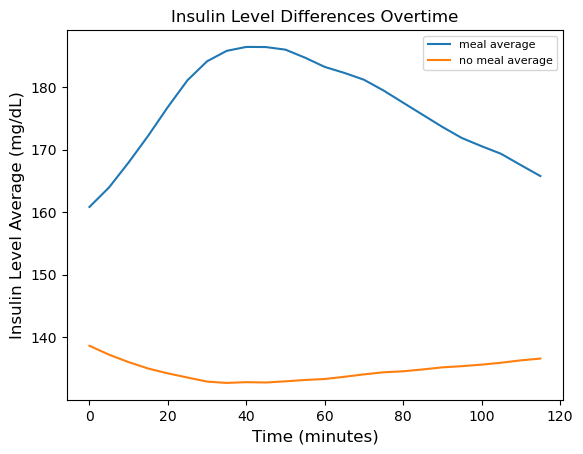

In [162]:
# VISUALIZE meal and no meal data
# average meal and no meal data based on time
x = meal_df.mean().tolist()
y = nomeal_df.mean().tolist()
    
# get time - idx * 5 minutes
z = []
for val in x: z.append(x.index(val)*5)
    
# line chart
    
# meal average from start of meal to end
plt.plot(z, x, label='meal average')

# no meal average over time
plt.plot(z, y, label='no meal average')

# labels
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Insulin Level Average (mg/dL)', fontsize=12)
plt.title('Insulin Level Differences Overtime')

# legend
plt.legend(loc="upper right", prop={'size': 8})

### Feature Engineering
Features are derived from the glucose measurements such as maximum, minimum, and mean glucose levels within each window.

Time-related features include duration since last meal to capture potential delays in glucose absorption.

In [165]:
# Function to extract key features from glucose data for model training
def prepare_data(data, string):
    # Define the structure of the DataFrame to hold our extracted features
    column = ['maxval', 'firstval', 'indexof_max', 'indexof_first', 'class']
    df = pd.DataFrame(columns=column)
 
    # Calculate the maximum glucose value for each period (meal or no-meal)
    df['maxval'] = data.max(axis=1)

    # Capture the initial glucose value at the start of each period
    df['firstval'] = data.iloc[:, 0]
    
    # Calculate the time (in minutes) to the peak glucose value from the start of the period
    df['indexof_max'] = (data.idxmax(axis=1).astype('int64') - 24).abs() * 5
    df['indexof_first'] = 0  # Set starting index time to 0 for reference
    
    # Calculate the average rate of change between consecutive glucose measurements
    df['avg_rate_change'] = data.diff(axis=1).abs().mean(axis=1)

    # Calculate the approximate area under the curve (AUC) using the trapezoidal rule
    df['auc'] = np.trapz(data, dx=5, axis=1) 
    
    # Label data as '1' for meal periods and '0' for no-meal periods based on the input identifier
    df['class'] = 1 if string == 'meal_df' else 0
    return df

In [167]:
# Prepare and extract features from both meal and no-meal dataframes
maxvalues_meal = prepare_data(meal_df, 'meal_df')
maxvalues_nomeal = prepare_data(nomeal_df, 'nomeal_df')
    
# Combine the features from meal and no-meal data into a single DataFrame using concat
maxvalues_combined = pd.concat([maxvalues_meal, maxvalues_nomeal], ignore_index=True)

# Define new features based on the extracted data for training the model
features = pd.DataFrame(columns=['max_first_dff', 'index_max_first_dff', 'avg_rate_change', 'auc', 'class'])

# max_first_dff is the relative change in glucose level from the start to the peak
features['max_first_dff'] = (((maxvalues_combined['maxval'] - maxvalues_combined['firstval']) / maxvalues_combined['firstval']) + 1).round(3)
# index_max_first_dff is the time difference in minutes to the peak glucose value from the start
features['index_max_first_dff'] = (maxvalues_combined['indexof_max'] - maxvalues_combined['indexof_first']).astype('int64') + 1
features['avg_rate_change'] = maxvalues_combined['avg_rate_change']
features['auc'] = maxvalues_combined['auc']
features['class'] = maxvalues_combined['class']

# Split the features into training and testing datasets for model validation
x_data = features[['max_first_dff', 'index_max_first_dff', 'avg_rate_change', 'auc']]
y_data = features['class']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)

# Display the features DataFrame to verify the structured data
features

,max_first_dff,index_max_first_dff,avg_rate_change,auc,class
0,1.145,11,5.130435,28775.0,1
1,1.590,81,6.347826,10360.0,1
2,1.075,31,4.000000,22440.0,1
3,1.704,56,6.826087,20112.5,1
4,3.636,1,7.173913,15022.5,1
...,...,...,...,...,...
1645,1.170,36,2.347826,11730.0,0
1646,1.009,111,1.521739,10962.5,0
1647,1.092,1,2.391304,8007.5,0
1648,5.519,1,10.391304,18352.5,0


### Supervised Machine Learning and Evaluation
This section of the code involves training and evaluating four different machine learning models using the features extracted from the glucose data.

In [247]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [212]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train_scaled, y_train)
predictions = clf.predict(x_test_scaled)
print(classification_report(y_test, predictions))

cv_scores = cross_val_score(clf, x_train_scaled, y_train, cv=10)
print("CV mean score: ", cv_scores.mean())

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       237
           1       0.59      0.58      0.58        93

    accuracy                           0.77       330
   macro avg       0.71      0.71      0.71       330
weighted avg       0.77      0.77      0.77       330

CV mean score:  0.7560606060606061


In [214]:
neigh = KNeighborsClassifier()
param_grid = {'n_neighbors': [2, 3, 5, 7, 9]}
grid_search = GridSearchCV(neigh, param_grid, cv=10)
grid_search.fit(x_train_scaled, y_train)
predictions1 = grid_search.predict(x_test_scaled)
print("K Neighbors")
print(classification_report(y_test, predictions1))
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

K Neighbors
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       237
           1       0.69      0.60      0.64        93

    accuracy                           0.81       330
   macro avg       0.77      0.75      0.76       330
weighted avg       0.81      0.81      0.81       330

Best parameters:  {'n_neighbors': 9}
Best cross-validation score:  0.803030303030303


In [222]:
random = RandomForestClassifier(random_state=0)
param_grid = {
  'n_estimators': [50, 100, 200],
  'max_features': ['sqrt', 'log2'],
  'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(random, param_grid, cv=10)
grid_search.fit(x_train_scaled, y_train)
predictions2 = grid_search.predict(x_test_scaled)
print(classification_report(y_test, predictions2)) 
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       237
           1       0.70      0.60      0.65        93

    accuracy                           0.82       330
   macro avg       0.78      0.75      0.76       330
weighted avg       0.81      0.82      0.81       330

Best parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best cross-validation score:  0.8098484848484849


In [226]:
gradient = GradientBoostingClassifier(random_state=0)
param_grid = {
  'n_estimators': [100, 200, 300],
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(gradient, param_grid, cv=10)
grid_search.fit(x_train_scaled, y_train)
predictions4 = grid_search.predict(x_test_scaled)
print("Gradient Boosting Classifier")
print(classification_report(y_test, predictions4))   
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Gradient Boosting Classifier
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       237
           1       0.71      0.58      0.64        93

    accuracy                           0.82       330
   macro avg       0.78      0.74      0.76       330
weighted avg       0.81      0.82      0.81       330

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score:  0.8196969696969697


### Unsupervised Learning and Evaluation
#### with raw data

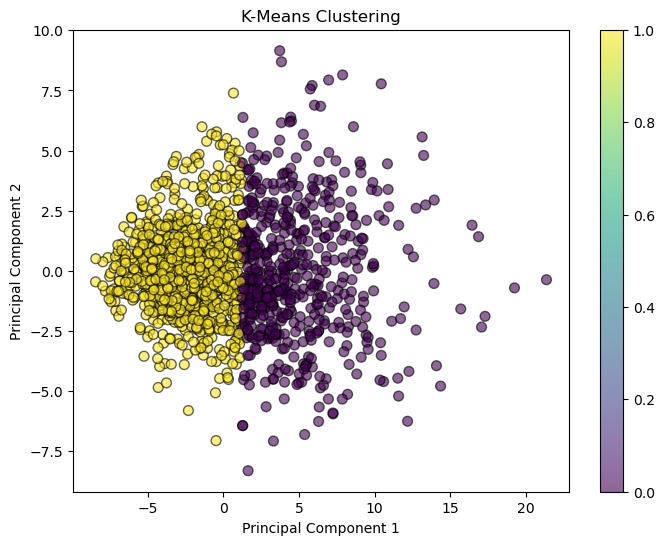

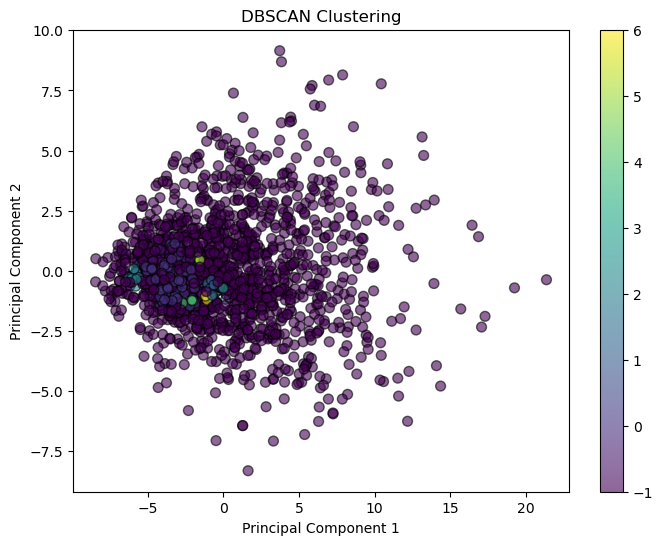

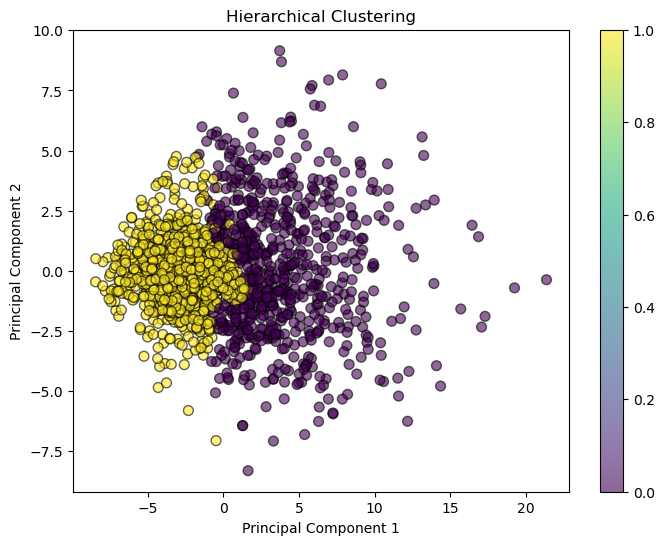

K-Means Silhouette Score: 0.46
DBSCAN Silhouette Score: -0.38
Hierarchical Clustering Silhouette Score: 0.41


In [284]:
# Labeling and combining dataframes for visualization purposes
meal_df['label'] = 1
nomeal_df['label'] = 0
data = pd.concat([meal_df, nomeal_df], ignore_index=True)

# Prepare features for clustering
features = data.drop('label', axis=1)
labels = data['label']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA for dimension reduction
pca = PCA(n_components=2)
features_reduced = pca.fit_transform(features_scaled)

# Define a function to plot clusters
def plot_clusters(data, clusters, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_clusters = kmeans.fit_predict(features_scaled)
plot_clusters(features_reduced, kmeans_clusters, 'K-Means Clustering')

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(features_scaled)
plot_clusters(features_reduced, dbscan_clusters, 'DBSCAN Clustering')

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(features_scaled)
plot_clusters(features_reduced, hierarchical_clusters, 'Hierarchical Clustering')

# Calculate Silhouette Scores
kmeans_silhouette = silhouette_score(features_scaled, kmeans_clusters)
dbscan_silhouette = silhouette_score(features_scaled, dbscan_clusters)
hierarchical_silhouette = silhouette_score(features_scaled, hierarchical_clusters)

print(f'K-Means Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.2f}')


#### with features data

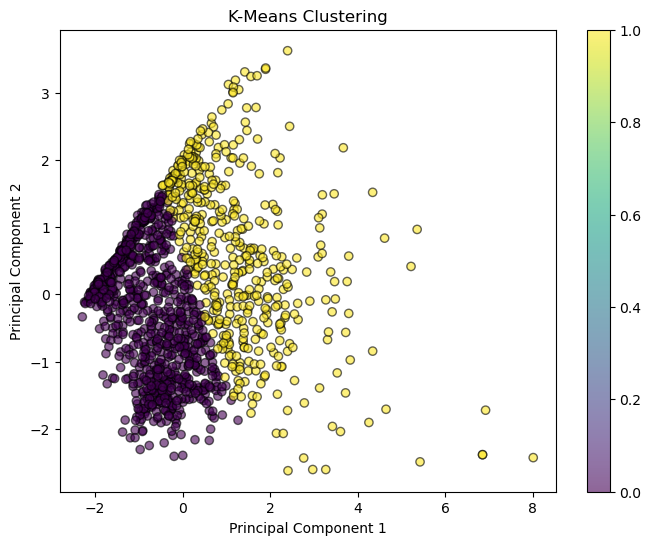

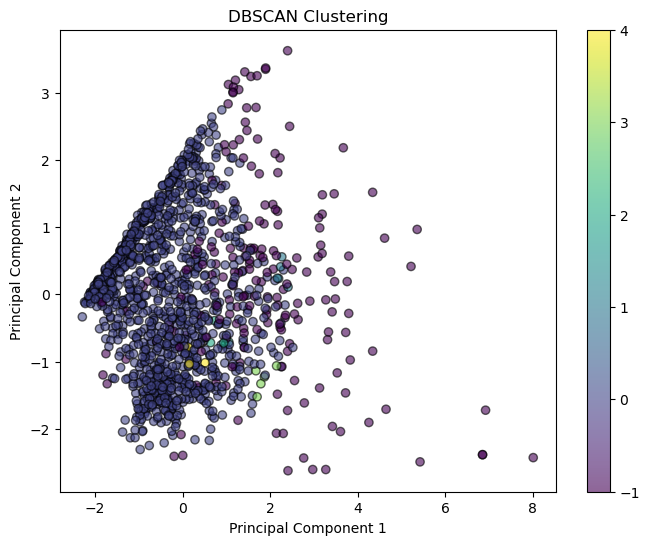

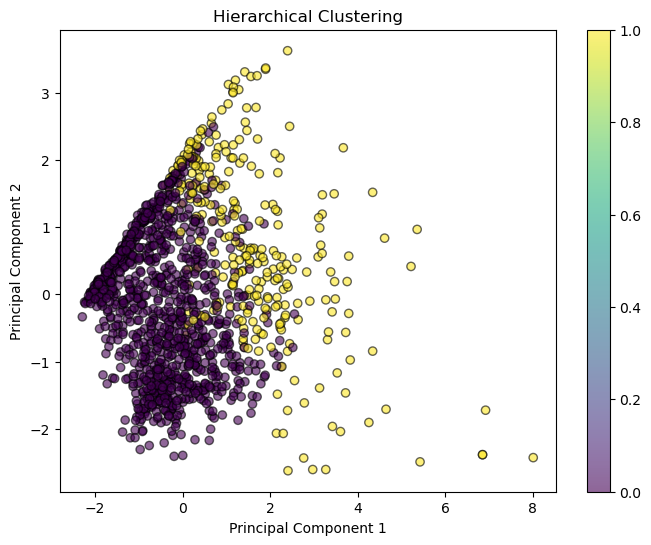

K-Means Silhouette Score: 0.30
DBSCAN Silhouette Score: -0.08002868192124156
Hierarchical Clustering Silhouette Score: 0.32


In [292]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Clustering with KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_clusters = kmeans.fit_predict(x_train_scaled)

# Clustering with DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(x_train_scaled)

# Clustering with Agglomerative Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(x_train_scaled)

# PCA for dimension reduction to 2D for visualization
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)

# Function to plot clusters
def plot_clusters(data, clusters, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', edgecolor='k', alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.show()

# Visualize the clustering results
plot_clusters(x_train_pca, kmeans_clusters, 'K-Means Clustering')
plot_clusters(x_train_pca, dbscan_clusters, 'DBSCAN Clustering')
plot_clusters(x_train_pca, hierarchical_clusters, 'Hierarchical Clustering')

# Evaluate using Silhouette Score
kmeans_silhouette = silhouette_score(x_train_scaled, kmeans_clusters)
dbscan_silhouette = silhouette_score(x_train_scaled, dbscan_clusters) if len(set(dbscan_clusters)) > 1 else 'Undefined'
hierarchical_silhouette = silhouette_score(x_train_scaled, hierarchical_clusters)

print(f'K-Means Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')
print(f'Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.2f}')

# Generate the linkage matrix for dendrogram
linked = linkage(x_train_scaled, method='ward')


#### In comparing clustering methods on raw and feature-extracted data, K-Means consistently outperforms DBSCAN and Hierarchical clustering. 

#### With raw data, K-Means achieved a Silhouette Score of 0.46, which indicates reasonably good cluster separation and cohesion. Hierarchical clustering also performed decently on raw data with a score of 0.41. DBSCAN, however, struggled in both scenarios, showing negative scores, which suggest poor clustering with possible misassignments. 

#### Feature-extracted data didn't fare as well across methods, with K-Means leading at a score of 0.30, indicating that raw data might be more suitable for these clustering algorithms in this case.